In [57]:
import pandas as pd
import numpy as np
import json
import nltk
import string
import re
import sys
sys.path.append("../")
from scripts.start import iberEval, sexists
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Import data

In [41]:
tweets, categories = iberEval()

In [14]:
np.unique(categories)

array(['derailing', 'discredit', 'dominance', 'sexual_harassment',
       'stereotype'], dtype='<U17')

In [85]:
from collections import Counter
Counter(categories)

Counter({'discredit': 943,
         'sexual_harassment': 410,
         'derailing': 29,
         'stereotype': 137,
         'dominance': 49})

## Preprocess & build TFIDF

In [46]:
def tokenize_and_lemmatize(text):
    text = re.sub("[@]\w+", "", text) # remove tags
    # remove punctuation
    table = text.maketrans({key: None for key in string.punctuation})
    text = text.translate(table)
    text = re.sub("(http)\w+", "", text) # remove links
    tokens = nltk.word_tokenize(text)
    #lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

In [43]:
lemmatizer = WordNetLemmatizer()
englishwords = stopwords.words('english')

In [47]:
tfidf_vec = TfidfVectorizer(max_df=0.9, 
                        max_features=10000,
                        min_df=5, 
                        stop_words=englishwords, 
                        tokenizer=tokenize_and_lemmatize, 
                        ngram_range=(1,1))

In [48]:
tfidf_mat = tfidf_vec.fit_transform(tweets)
tfidf_mat.shape

(1568, 507)

## K-Means clustering, keyword extraction & visualization

In [49]:
clusters = MiniBatchKMeans(n_clusters=5, init_size=1024, batch_size=2048, random_state=20).fit_predict(tfidf_mat)

In [81]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    
    pca = PCA(n_components=2).fit_transform(data.todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data.todense()))
    
    
    #idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels
    label_subset = [cm.hsv(i/max_label) for i in label_subset]
    
    f, ax = plt.subplots(1, 2, figsize=(20, 8))
    
    ax[0].scatter(pca[:, 0], pca[:, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[:, 0], tsne[:, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')

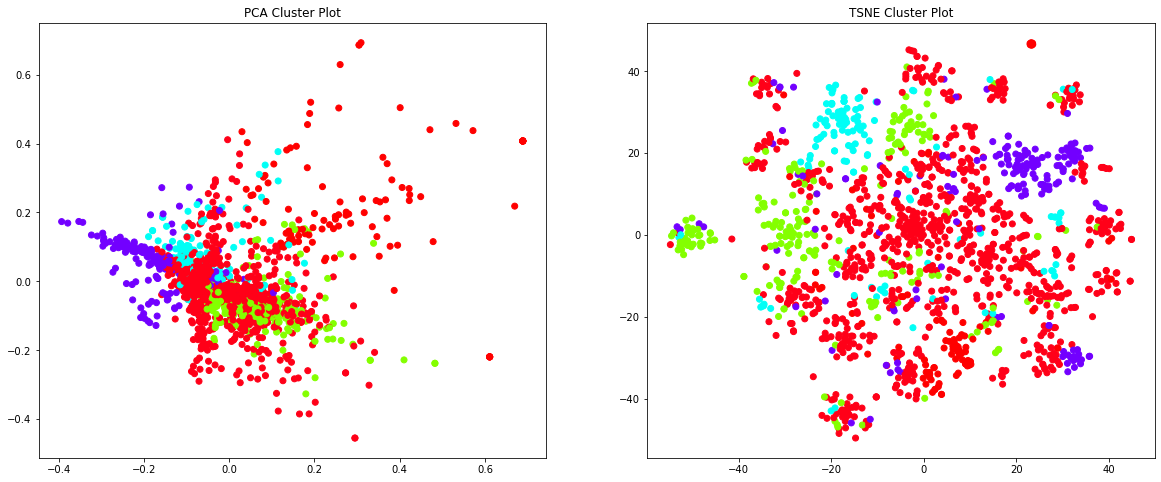

In [82]:
plot_tsne_pca(tfidf_mat, clusters)

In [70]:
#let's see cluster keywords
def get_top_keywords(data, clusters, labels, n_terms, categoryNames=None):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        if categoryNames is None:
            print('\nCluster {}'.format(i))
        else:
            print('\nCluster {}'.format(categoryNames[i]))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]][::-1]))
            
get_top_keywords(tfidf_mat, clusters, tfidf_vec.get_feature_names(), 10)


Cluster 0
stupid,bitch,cunt,fuck,’,fucking,ass,shit,u,lil

Cluster 1
hoe,pussy,bitch,’,ass,“,”,u,got,like

Cluster 2
whore,’,fucking,like,bitch,shut,fuck,calling,shit,boo

Cluster 3
women,men,rape,like,dick,yesallmen,dont,bitch,many,want

Cluster 4
bitch,dick,girl,woman,like,ass,slut,fuck,bitches,cunt


In [54]:
# Let's see actual categories keywords
#derailing', 'discredit', 'dominance', 'sexual_harassment','stereotype'
catNumbers = [0 if c == "derailing" else 1 if c == 'discredit' else 2 if c == 'dominance' else 3 if c == 'sexual_harassment' else 4 for c in categories]
get_top_keywords(tfidf_mat, np.array(catNumbers), tfidf_vec.get_feature_names(), 10, np.unique(categories))


Cluster derailing
women,rape,woman,men,dont,lol,every,want,man,dress

Cluster discredit
bitch,stupid,women,’,ass,like,girl,whore,hoe,slut

Cluster dominance
like,bitch,men,women,yesallmen,shut,get,whore,cock,account

Cluster sexual_harassment
dick,bitch,rape,cock,ass,fuck,suck,girl,like,pussy

Cluster stereotype
women,woman,dick,like,girl,one,bitch,bitches,yesallmen,going


Many words are shared between different categories, and its hard to tell some specifics, so it's hard to say that the categories are very sensible at first glance.
However, if we analyze the tweets that are labeled by different categories:

* derailing - usually tries to disregard women's issues by comparing with men, which is why those words are relevant. not too agressive language otherwise
* discredit - use of offensive vocabulary to insult people, usually women
* dominance - use of sexual language, usually to assert dominance of men over women
* sexual harrasment - use of sexual language
* stereotype - ?

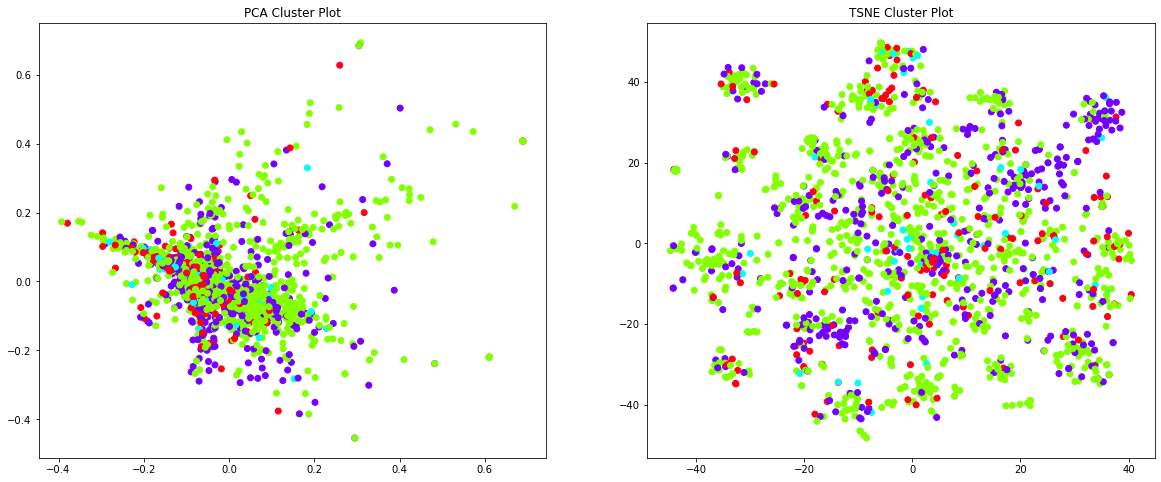

In [83]:
plot_tsne_pca(tfidf_mat, np.array(catNumbers))

## Second attempt - regular KMeans

Turns out its exactly the same as minibatch

In [59]:
km = KMeans(n_clusters=5)
km.fit(tfidf_mat)
clusters = np.array(km.labels_.tolist())
clusters

array([4, 4, 1, ..., 4, 3, 4])

In [68]:
#for each centroid, get ordered features by relevance
order_centroids =  km.cluster_centers_.argsort()[:, ::-1]
def getClusterWords(cluster, n=10):
    words = []
    for ind in order_centroids[cluster, :n]: # Print 6 words per cluster
        # old pandas version
        #words.append(vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0])
        words.append(tfidf_vec.get_feature_names()[ind])
    return ", ".join(words)

In [69]:
for i in range(5):
    print("Cluster {} words: {}".format(i, getClusterWords(i)))

Cluster 0 words: stupid, bitch, cunt, fuck, ’, fucking, ass, shit, u, lil
Cluster 1 words: hoe, pussy, bitch, ’, ass, “, ”, u, got, like
Cluster 2 words: whore, ’, fucking, like, bitch, shut, fuck, calling, shit, boo
Cluster 3 words: women, men, rape, like, dick, yesallmen, dont, bitch, many, want
Cluster 4 words: bitch, dick, girl, woman, like, ass, slut, fuck, bitches, cunt


We see some minor differences, but many words are the same, and we cant really infer a sensible topic/category to the generated clusters.